### Main script to train RNN type architectures on audio data with control parameters
* Loading/batching from audioDataloader
* Control parameter creation/manipulation from paramManager
* NN architectures found in utils.architectures
* Teacher forcing (using known targets as input) ratio can be changed to <1 to do professor forcing
* Training target can be specified by no. of steps, epochs or a loss value
* training parameters + model state dic + optimizer state dic are saved into a single python dic if savemodel=True 

To do:
* Put training/generation routines into its own script so it can be easily reused/ easier version management - but some variables then need to be imported into that script since these functions rely on many global variables defined here. All functions to be put in utils folder thereafter
* Better integration with the attention training (in another notebook currently)
* streamline checkpoint saving - now ok for all conditions except for saving after each epoch

In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager
from utils.architectures import RNN
from utils.myUtils import time_taken,plot_signal
#import utils.training as process

import matplotlib.pylab as plt
%matplotlib inline

In [7]:
# Read/write directory parameters
#*************************************
datadir = 'data/synth/synth6476OddEvenConstantSlopeTransients_x2scaled/dataset'
paramdir = 'data/synth/synth6476OddEvenConstantSlopeTransients_x2scaled/dataparams'
savemodeldir = 'model/saved/paper'
savename = 'model'
loadmodelpath = 'model/saved/paper/2019-01-22_11-51-12_model_epoch0_step10001.tar' #shared path to load model, optimizer and TrainingParams

# Pytorch parameters
#*************************************
#--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 1000 #if 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = False #NOTE: if continuing training from previous save remember to also enable loadTrainingParams

# Training parameters
#*************************************
loadTrainingParams = False #if true will ignore the below and load training params from a .pth as specified in loadmodelpath
sr = 16000
seqLen = 256
stride = 1
batch_size = 256
num_epochs = 1
lr = 0.005
log_interval = 50
max_steps = 13000 #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch
loss_target = 1.0 #alternative to using max_steps, training will end if model achieves this loss target
teacher_forcing_ratio = 1.0 #stochastically use either targets or own predictions as input for training. Set to 1 to always use targets

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 200

#Network parameters
#*************************************
n_layers = 4
hidden_size = 40
output_size = 256 #also the no. of mu-law intervals. Both encoding and decoding will depend on this for consistency

#Pre-processing parameters
#*************************************
noise = 0.1 #noise at 10% of signal
lowNote =  64
hiNote = 76
prop = ['instID','volume','midiPitch']

#Define variables that change between runs (these should not be changed!)
#*************************************
list_of_losses = []
start_epoch = 0
start_step = 0


if loadTrainingParams: #will overwrite the above if True
    print("Loading existing training params...")
    checkpoint = torch.load(loadmodelpath, map_location=device) #map_location in case using cpu
    
    list_of_losses = checkpoint['loss']
    start_epoch = checkpoint['epoch']
    start_step = checkpoint['step']
    sr = checkpoint['sample_rate']
    start = checkpoint['start_time']
    datadir = checkpoint['datadir']
    paramdir = checkpoint['paramdir']
    savemodeldir = checkpoint['savemodeldir']
    seqLen = checkpoint['seqLen']
    stride = checkpoint['stride']
    batch_size = checkpoint['batch_size']
    num_epochs = checkpoint['num_epochs'] #can comment out if want to change
    lr = checkpoint['lr']
    log_interval = checkpoint['log_interval']
    max_steps = checkpoint['max_steps'] #can comment out if want to change
    teacher_forcing_ratio = checkpoint['teacher_forcing_ratio']                   
    prop = checkpoint['prop']
    output_size = checkpoint['output_size']
    hidden_size = checkpoint['hidden_size']
    n_layers = checkpoint['n_layers']
    noise = checkpoint['noise']
    lowNote = checkpoint['lowNote']
    hiNote = checkpoint['hiNote']
    
    for key in checkpoint:
        if (key != 'model_state_dict') and (key != 'optimizer_state_dict'): 
            print(key,'=',checkpoint[key])
    

# Loading warnings below    
if loadmodel and loadTrainingParams:
    print('Will continue training from a previous checkpoint...')
if not loadmodel and not loadTrainingParams:
    print('Will start training from scratch...')
if loadmodel and not loadTrainingParams:
    print('Will load existing model weights but not use trained parameters! (Are you sure?)')
if not loadmodel and loadTrainingParams:
    print('Will initialize new model but use parameters trained from a previous run! (Are you sure?)')
print('using',device, 'pytorch',torch.version.cuda)

Starting training from scratch...
using cuda:0 pytorch 9.0


In [6]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'midiPitch', 'volume'])


In [7]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(output_size,0,1) #initialize the mu-law encodings
targetcoding = mulaw(output_size)
rescalePitch = normalizeDim('midiPitch',lowNote,hiNote)
rescaleAmp = normalizeDim('volume',0,0.9)
cond_size = len(prop)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=prop,
                                  transform=transform.Compose([injectNoise(weight=noise),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]), 
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride, #for priming during generation
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=prop,
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 3120000
no. of steps per epoch is 12187
(256, 1)


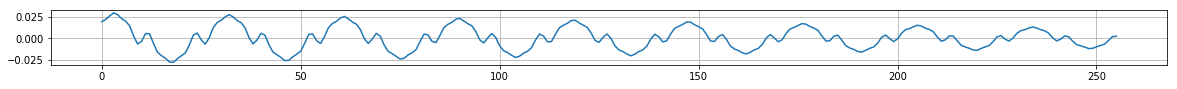

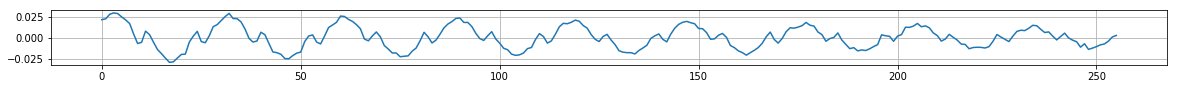

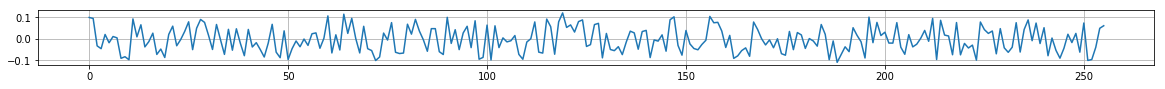

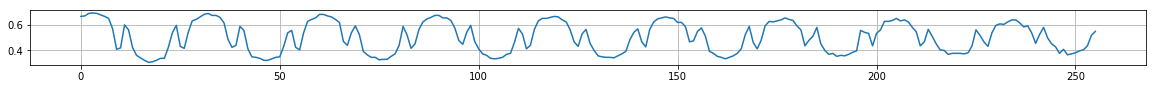

tensor([[0.8157, 0.0000, 0.7500, 0.7500],
        [0.2471, 0.0000, 0.7500, 0.7500],
        [0.1922, 0.0000, 0.7500, 0.7500],
        ...,
        [0.0824, 0.0000, 0.7500, 0.7500],
        [0.1098, 0.0000, 0.7500, 0.7500],
        [0.1176, 0.0000, 0.7500, 0.7500]])


In [8]:
#Just to visualize the audio encoding in dataloader

print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

# first pick a section of audio from the dataset
samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

#now inject noise weighted by the signal amplitude (to get roughly constant signal-to-noise ratio across data samples)
samp2 = samp + 0.1 * np.random.uniform(samp.min(), samp.max(), size=len(samp)).reshape(-1,1)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp2)), samp2) #just print one example from the batch
plt.grid()
plt.show()

#if required the noise can be fixed as well (constant=True) - see injectNoise() in transforms.py
samp3 = samp + 0.1 * np.random.uniform(-1, 1, size=len(samp)).reshape(-1,1)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp3)), samp3) #just print one example from the batch
plt.grid()
plt.show()

#we then encode the sampling to mu-law
samp_coded = audiocoding(samp2)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp_coded)), samp_coded) #just print one example from the batch
plt.grid()
plt.show()

for step, (inp,target) in enumerate(train_loader):
        print(inp[0])
        break

In [9]:
# Define the training cycle
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    ave_loss_over_steps = 0
    current_loss = 10000 #set at a large initial value 
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)

        # Forward + Backward + Optimize
        hidden = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio or i==0 else False
            #similar to Bengio et al, Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
            
            if use_teacher_forcing: #feed the target as the next input 
                outputs, hidden = model(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation detach()
                predicted_sample = targetcoding.index2float(topi)
                
            else: #feed its own predictions (output of t-1) as next input
                own_inp = inp[:,i,:].clone()
                own_inp[:,0] = torch.squeeze(torch.tensor(audiocoding(predicted_sample),
                                                          dtype=torch.float,device=device,requires_grad=True),1)
                outputs, hidden = model(own_inp,hidden,batch_size)  #input dim: (batch, seq, feature)
                loss += criterion(outputs, torch.squeeze(target[:,i],1))
                
                outputs = nn.functional.log_softmax(outputs,dim=1)
                topv, topi = outputs.detach().topk(1)  #choose the strongest activation
                predicted_sample = targetcoding.index2float(topi)
                           
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            current_loss = ave_loss_over_steps/log_interval
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch, num_epochs, step+1, len(adataset)//batch_size, current_loss))
            
            list_of_losses.append(current_loss)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result, hs = generate(model,max_length)
            plot_signal(result,start=seqLen-1)
            model.train() #put model back to training mode
        
        if savemodel_interval != 0 and savemodel:
            if (step+1) % savemodel_interval == 0:
                torch.save({ #the training parameters that will be saved
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': list_of_losses,
                'epoch': start_epoch+epoch,
                'step': start_step+step+1,
                'sample_rate': sr,
                'start_time': start,
                'datadir': datadir,
                'paramdir': paramdir,
                'savemodeldir': savemodeldir,
                'seqLen': seqLen,
                'stride': stride,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'lr': lr,
                'log_interval': log_interval,
                'max_steps': max_steps,
                'teacher_forcing_ratio': teacher_forcing_ratio,                    
                'prop': prop,
                'output_size': output_size,
                'hidden_size': hidden_size,
                'n_layers': n_layers,
                'noise': noise,
                'lowNote': lowNote,
                'hiNote': hiNote
                },                            
                '{}/{}_{}_epoch{}_step{}.tar'.format(
                    savemodeldir,start,savename,start_epoch+epoch,start_step+step+1))
                
                print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step+step+1))

        
        if step==max_steps or current_loss < loss_target:
            torch.save({ #the training parameters that will be saved
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': list_of_losses,
                'epoch': start_epoch+epoch,
                'step': start_step+step+1,
                'sample_rate': sr,
                'start_time': start,
                'datadir': datadir,
                'paramdir': paramdir,
                'savemodeldir': savemodeldir,
                'seqLen': seqLen,
                'stride': stride,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'lr': lr,
                'log_interval': log_interval,
                'max_steps': max_steps,
                'teacher_forcing_ratio': teacher_forcing_ratio,                    
                'prop': prop,
                'output_size': output_size,
                'hidden_size': hidden_size,
                'n_layers': n_layers,
                'noise': noise,
                'lowNote': lowNote,
                'hiNote': hiNote
                },                            
            '{}/{}_{}_epoch{}_step{}.tar'.format(
                savemodeldir,start,savename,start_epoch+epoch,start_step+step+1))

            print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step+step+1))
            break
 

 
def generate(model,max_length,primer=None,paramvect=None,returnHiddenSequence=False):
    
    hs=[] #list to save hidden states, function returns empty list if returnHiddenSequence=False 
    
    model.eval()
    with torch.no_grad():
        for p_inp,target in test_loader:
            if primer is not None:
                # must clone else primer is changed outside this function
                p_inp.data = primer.clone()
            seq = np.copy(p_inp[0,:,0])  #extract the original sample
            seq_mu = audiocoding(seq)  #mu-law
            p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
            break  
        generated = seq
        p_inp = p_inp.to(device)

        hidden = model.init_hidden().to(device)
        if returnHiddenSequence :
            hs.append(torch.squeeze(hidden).cpu().numpy())
        
        if p_inp.shape[1] > 1: #if priming with something with len>1
            for j in range(seqLen-1):  #build up hidden state
                _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.FloatTensor).to(device)
            if paramvect is not None:
                if callable(paramvect):
                    inp[:,1:] = torch.from_numpy(paramvect(i)).type(torch.FloatTensor).to(device)
                else:
                    inp[:,1:] = torch.from_numpy(paramvect).type(torch.FloatTensor).to(device)
                
            if returnHiddenSequence :
                hs.append(torch.squeeze(hidden).cpu().numpy())
                                       
        return generated, hs
        

In [10]:
# Initialize the network, optimizer and objective func
#*************************************
model = RNN(input_size=1,cond_size=cond_size,hidden_size=hidden_size,output_size=output_size,n_layers=n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if loadmodel: # load checkpoint if needed
    print("Loading existing model and optimizer state...")
    model.load_state_dict(torch.load(loadmodelpath, map_location=device)['model_state_dict'])
    optimizer.load_state_dict(torch.load(loadmodelpath, map_location=device)['optimizer_state_dict'])
    
criterion = nn.CrossEntropyLoss()

2019-01-22 11:51:12 Starting training at epoch0 step0...
2019-01-22 11:52:00 Epoch [0/1], Step [25/12187] Loss: 5.2211
2019-01-22 11:52:46 Epoch [0/1], Step [50/12187] Loss: 4.8554
2019-01-22 11:53:37 Epoch [0/1], Step [75/12187] Loss: 4.5849
2019-01-22 11:54:17 Epoch [0/1], Step [100/12187] Loss: 4.3080
2019-01-22 11:54:58 Epoch [0/1], Step [125/12187] Loss: 4.0433
2019-01-22 11:55:38 Epoch [0/1], Step [150/12187] Loss: 3.8171
2019-01-22 11:56:28 Epoch [0/1], Step [175/12187] Loss: 3.6131
2019-01-22 11:57:22 Epoch [0/1], Step [200/12187] Loss: 3.4431


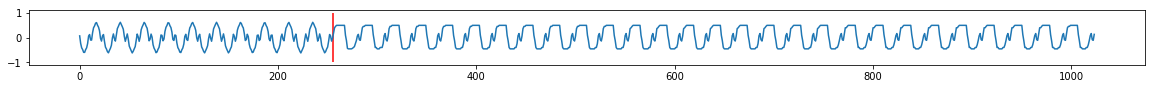

2019-01-22 11:58:24 Epoch [0/1], Step [225/12187] Loss: 3.3351
2019-01-22 11:59:05 Epoch [0/1], Step [250/12187] Loss: 3.3461
2019-01-22 11:59:45 Epoch [0/1], Step [275/12187] Loss: 3.2255
2019-01-22 12:00:26 Epoch [0/1], Step [300/12187] Loss: 3.0744
2019-01-22 12:01:22 Epoch [0/1], Step [325/12187] Loss: 3.0073
2019-01-22 12:02:18 Epoch [0/1], Step [350/12187] Loss: 2.9337
2019-01-22 12:03:12 Epoch [0/1], Step [375/12187] Loss: 2.8667
2019-01-22 12:04:01 Epoch [0/1], Step [400/12187] Loss: 2.8162


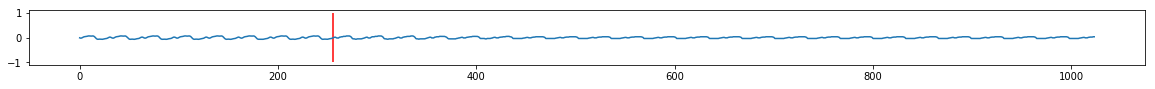

2019-01-22 12:05:00 Epoch [0/1], Step [425/12187] Loss: 2.8114
2019-01-22 12:06:00 Epoch [0/1], Step [450/12187] Loss: 2.7435
2019-01-22 12:06:44 Epoch [0/1], Step [475/12187] Loss: 2.6926
2019-01-22 12:07:27 Epoch [0/1], Step [500/12187] Loss: 2.6622
2019-01-22 12:08:08 Epoch [0/1], Step [525/12187] Loss: 2.6337
2019-01-22 12:08:49 Epoch [0/1], Step [550/12187] Loss: 2.6130
2019-01-22 12:09:29 Epoch [0/1], Step [575/12187] Loss: 2.5844
2019-01-22 12:10:08 Epoch [0/1], Step [600/12187] Loss: 2.5976


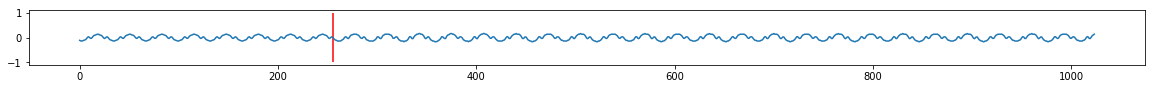

2019-01-22 12:10:52 Epoch [0/1], Step [625/12187] Loss: 2.5943
2019-01-22 12:11:32 Epoch [0/1], Step [650/12187] Loss: 2.4966
2019-01-22 12:12:12 Epoch [0/1], Step [675/12187] Loss: 2.5048
2019-01-22 12:12:52 Epoch [0/1], Step [700/12187] Loss: 2.4348
2019-01-22 12:13:32 Epoch [0/1], Step [725/12187] Loss: 2.4743
2019-01-22 12:14:11 Epoch [0/1], Step [750/12187] Loss: 2.4206
2019-01-22 12:14:51 Epoch [0/1], Step [775/12187] Loss: 2.4092
2019-01-22 12:15:31 Epoch [0/1], Step [800/12187] Loss: 2.3866


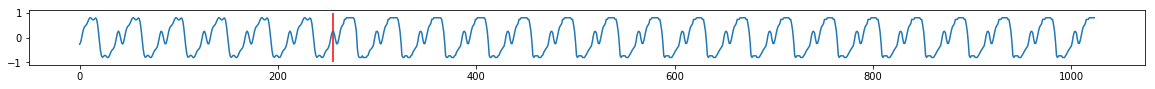

2019-01-22 12:16:15 Epoch [0/1], Step [825/12187] Loss: 2.3709
2019-01-22 12:16:54 Epoch [0/1], Step [850/12187] Loss: 2.3442
2019-01-22 12:17:34 Epoch [0/1], Step [875/12187] Loss: 2.3036
2019-01-22 12:18:14 Epoch [0/1], Step [900/12187] Loss: 2.3465
2019-01-22 12:18:53 Epoch [0/1], Step [925/12187] Loss: 2.3848
2019-01-22 12:19:33 Epoch [0/1], Step [950/12187] Loss: 2.3490
2019-01-22 12:20:12 Epoch [0/1], Step [975/12187] Loss: 2.2627
2019-01-22 12:20:53 Epoch [0/1], Step [1000/12187] Loss: 2.2250


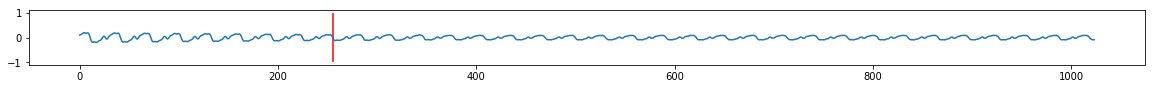

model 2019-01-22_11-51-12_model_epoch0_step1000.tar saved
2019-01-22 12:21:37 Epoch [0/1], Step [1025/12187] Loss: 2.2297
2019-01-22 12:22:18 Epoch [0/1], Step [1050/12187] Loss: 2.2231
2019-01-22 12:22:57 Epoch [0/1], Step [1075/12187] Loss: 2.2428
2019-01-22 12:23:37 Epoch [0/1], Step [1100/12187] Loss: 2.1877
2019-01-22 12:24:17 Epoch [0/1], Step [1125/12187] Loss: 2.2074
2019-01-22 12:24:57 Epoch [0/1], Step [1150/12187] Loss: 2.2634
2019-01-22 12:25:36 Epoch [0/1], Step [1175/12187] Loss: 2.1617
2019-01-22 12:26:16 Epoch [0/1], Step [1200/12187] Loss: 2.1512


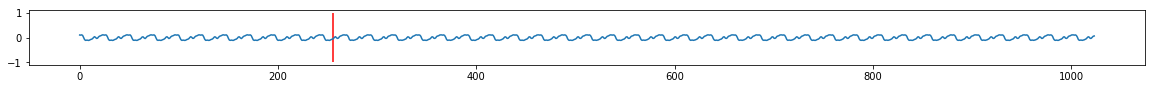

2019-01-22 12:26:59 Epoch [0/1], Step [1225/12187] Loss: 2.1397
2019-01-22 12:27:39 Epoch [0/1], Step [1250/12187] Loss: 2.1331
2019-01-22 12:28:19 Epoch [0/1], Step [1275/12187] Loss: 2.1561
2019-01-22 12:28:59 Epoch [0/1], Step [1300/12187] Loss: 2.1275
2019-01-22 12:29:39 Epoch [0/1], Step [1325/12187] Loss: 2.1128
2019-01-22 12:30:19 Epoch [0/1], Step [1350/12187] Loss: 2.3945
2019-01-22 12:30:58 Epoch [0/1], Step [1375/12187] Loss: 2.2116
2019-01-22 12:31:39 Epoch [0/1], Step [1400/12187] Loss: 2.0863


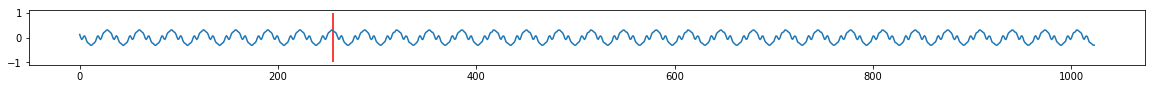

2019-01-22 12:32:22 Epoch [0/1], Step [1425/12187] Loss: 2.0974
2019-01-22 12:33:02 Epoch [0/1], Step [1450/12187] Loss: 2.0781
2019-01-22 12:33:41 Epoch [0/1], Step [1475/12187] Loss: 2.0739
2019-01-22 12:34:21 Epoch [0/1], Step [1500/12187] Loss: 2.0467
2019-01-22 12:35:00 Epoch [0/1], Step [1525/12187] Loss: 2.0331
2019-01-22 12:35:40 Epoch [0/1], Step [1550/12187] Loss: 2.0363
2019-01-22 12:36:20 Epoch [0/1], Step [1575/12187] Loss: 2.0296
2019-01-22 12:37:00 Epoch [0/1], Step [1600/12187] Loss: 2.0890


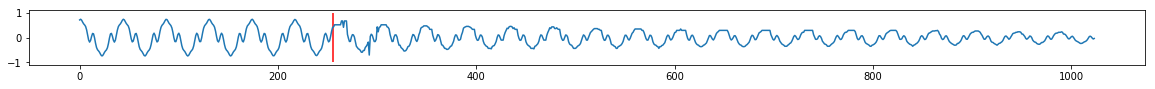

2019-01-22 12:37:43 Epoch [0/1], Step [1625/12187] Loss: 2.1401
2019-01-22 12:38:22 Epoch [0/1], Step [1650/12187] Loss: 2.0325
2019-01-22 12:39:02 Epoch [0/1], Step [1675/12187] Loss: 1.9747
2019-01-22 12:39:42 Epoch [0/1], Step [1700/12187] Loss: 1.9839
2019-01-22 12:40:21 Epoch [0/1], Step [1725/12187] Loss: 1.9751
2019-01-22 12:41:01 Epoch [0/1], Step [1750/12187] Loss: 1.9806
2019-01-22 12:41:41 Epoch [0/1], Step [1775/12187] Loss: 1.9748
2019-01-22 12:42:21 Epoch [0/1], Step [1800/12187] Loss: 1.9752


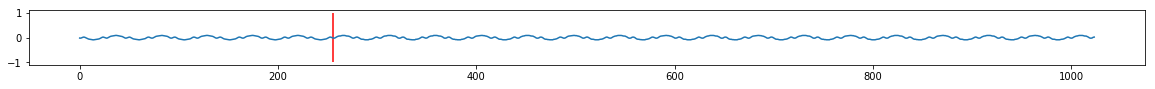

2019-01-22 12:43:04 Epoch [0/1], Step [1825/12187] Loss: 1.9834
2019-01-22 12:43:43 Epoch [0/1], Step [1850/12187] Loss: 2.0002
2019-01-22 12:44:23 Epoch [0/1], Step [1875/12187] Loss: 1.9388
2019-01-22 12:45:03 Epoch [0/1], Step [1900/12187] Loss: 1.9505
2019-01-22 12:45:42 Epoch [0/1], Step [1925/12187] Loss: 1.9230
2019-01-22 12:46:22 Epoch [0/1], Step [1950/12187] Loss: 1.9277
2019-01-22 12:47:01 Epoch [0/1], Step [1975/12187] Loss: 1.9271
2019-01-22 12:47:41 Epoch [0/1], Step [2000/12187] Loss: 1.9177


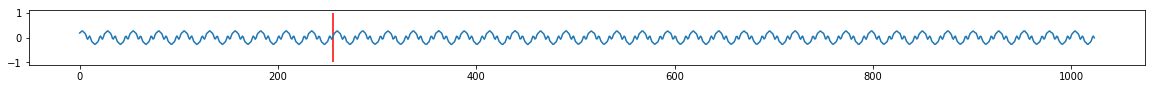

model 2019-01-22_11-51-12_model_epoch0_step2000.tar saved
2019-01-22 12:48:24 Epoch [0/1], Step [2025/12187] Loss: 2.0040
2019-01-22 12:49:04 Epoch [0/1], Step [2050/12187] Loss: 1.9336
2019-01-22 12:49:43 Epoch [0/1], Step [2075/12187] Loss: 1.9330
2019-01-22 12:50:23 Epoch [0/1], Step [2100/12187] Loss: 1.8975
2019-01-22 12:51:03 Epoch [0/1], Step [2125/12187] Loss: 1.9329
2019-01-22 12:51:43 Epoch [0/1], Step [2150/12187] Loss: 1.9032
2019-01-22 12:52:22 Epoch [0/1], Step [2175/12187] Loss: 1.8635
2019-01-22 12:53:03 Epoch [0/1], Step [2200/12187] Loss: 1.8944


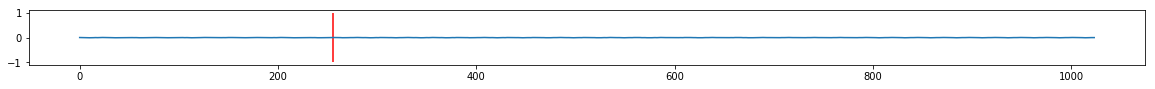

2019-01-22 12:53:50 Epoch [0/1], Step [2225/12187] Loss: 1.8638
2019-01-22 12:54:33 Epoch [0/1], Step [2250/12187] Loss: 1.8767
2019-01-22 12:55:15 Epoch [0/1], Step [2275/12187] Loss: 1.8875
2019-01-22 12:55:58 Epoch [0/1], Step [2300/12187] Loss: 1.8515
2019-01-22 12:56:42 Epoch [0/1], Step [2325/12187] Loss: 1.8405
2019-01-22 12:57:24 Epoch [0/1], Step [2350/12187] Loss: 1.8465
2019-01-22 12:58:07 Epoch [0/1], Step [2375/12187] Loss: 1.8322
2019-01-22 12:58:51 Epoch [0/1], Step [2400/12187] Loss: 1.8753


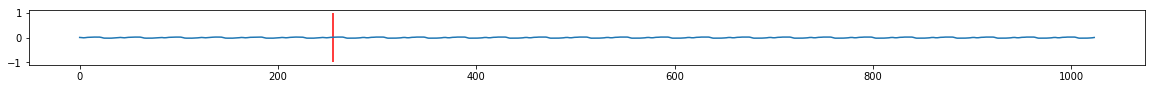

2019-01-22 12:59:41 Epoch [0/1], Step [2425/12187] Loss: 1.8935
2019-01-22 13:00:22 Epoch [0/1], Step [2450/12187] Loss: 1.8345
2019-01-22 13:01:03 Epoch [0/1], Step [2475/12187] Loss: 1.8152
2019-01-22 13:01:45 Epoch [0/1], Step [2500/12187] Loss: 1.8452
2019-01-22 13:02:27 Epoch [0/1], Step [2525/12187] Loss: 1.8252
2019-01-22 13:03:09 Epoch [0/1], Step [2550/12187] Loss: 1.8591
2019-01-22 13:03:51 Epoch [0/1], Step [2575/12187] Loss: 1.8284
2019-01-22 13:04:32 Epoch [0/1], Step [2600/12187] Loss: 1.8224


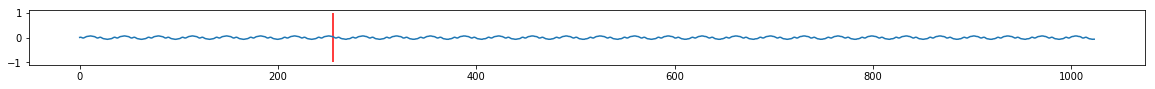

2019-01-22 13:05:17 Epoch [0/1], Step [2625/12187] Loss: 1.8164
2019-01-22 13:05:57 Epoch [0/1], Step [2650/12187] Loss: 1.8217
2019-01-22 13:06:37 Epoch [0/1], Step [2675/12187] Loss: 1.8086
2019-01-22 13:07:17 Epoch [0/1], Step [2700/12187] Loss: 1.8568
2019-01-22 13:07:59 Epoch [0/1], Step [2725/12187] Loss: 1.8063
2019-01-22 13:08:39 Epoch [0/1], Step [2750/12187] Loss: 1.8331
2019-01-22 13:09:19 Epoch [0/1], Step [2775/12187] Loss: 1.8469
2019-01-22 13:09:58 Epoch [0/1], Step [2800/12187] Loss: 1.7978


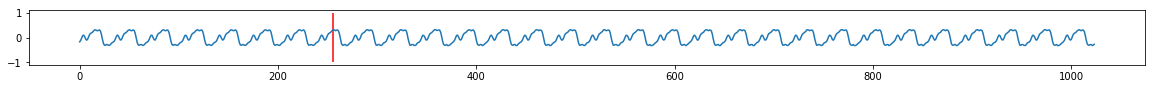

2019-01-22 13:10:42 Epoch [0/1], Step [2825/12187] Loss: 1.7770
2019-01-22 13:11:22 Epoch [0/1], Step [2850/12187] Loss: 1.7697
2019-01-22 13:12:03 Epoch [0/1], Step [2875/12187] Loss: 1.7868
2019-01-22 13:12:46 Epoch [0/1], Step [2900/12187] Loss: 1.7777
2019-01-22 13:13:30 Epoch [0/1], Step [2925/12187] Loss: 1.7537
2019-01-22 13:14:15 Epoch [0/1], Step [2950/12187] Loss: 1.9450
2019-01-22 13:14:59 Epoch [0/1], Step [2975/12187] Loss: 1.8704
2019-01-22 13:15:41 Epoch [0/1], Step [3000/12187] Loss: 1.7724


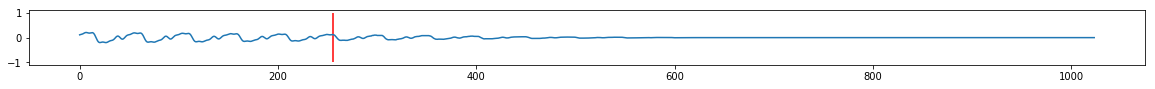

model 2019-01-22_11-51-12_model_epoch0_step3000.tar saved
2019-01-22 13:16:30 Epoch [0/1], Step [3025/12187] Loss: 1.7657
2019-01-22 13:17:13 Epoch [0/1], Step [3050/12187] Loss: 1.7335
2019-01-22 13:17:56 Epoch [0/1], Step [3075/12187] Loss: 1.7362
2019-01-22 13:18:38 Epoch [0/1], Step [3100/12187] Loss: 1.7622
2019-01-22 13:19:21 Epoch [0/1], Step [3125/12187] Loss: 1.7571
2019-01-22 13:20:03 Epoch [0/1], Step [3150/12187] Loss: 1.7246
2019-01-22 13:20:46 Epoch [0/1], Step [3175/12187] Loss: 1.7628
2019-01-22 13:21:28 Epoch [0/1], Step [3200/12187] Loss: 1.7395


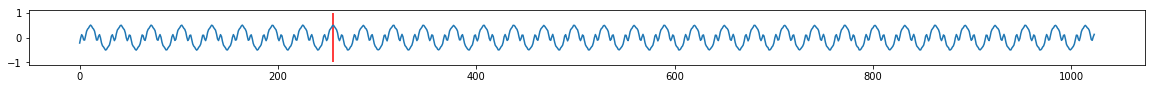

2019-01-22 13:22:12 Epoch [0/1], Step [3225/12187] Loss: 1.7785
2019-01-22 13:22:53 Epoch [0/1], Step [3250/12187] Loss: 1.7220
2019-01-22 13:23:33 Epoch [0/1], Step [3275/12187] Loss: 1.6933
2019-01-22 13:24:14 Epoch [0/1], Step [3300/12187] Loss: 1.7369
2019-01-22 13:24:54 Epoch [0/1], Step [3325/12187] Loss: 1.7010
2019-01-22 13:25:34 Epoch [0/1], Step [3350/12187] Loss: 1.6972
2019-01-22 13:26:15 Epoch [0/1], Step [3375/12187] Loss: 1.7795
2019-01-22 13:26:56 Epoch [0/1], Step [3400/12187] Loss: 1.7791


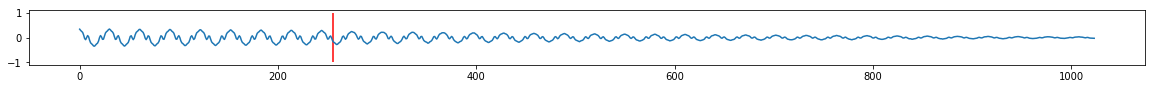

2019-01-22 13:27:40 Epoch [0/1], Step [3425/12187] Loss: 1.7838
2019-01-22 13:28:20 Epoch [0/1], Step [3450/12187] Loss: 1.9073
2019-01-22 13:29:00 Epoch [0/1], Step [3475/12187] Loss: 1.7259
2019-01-22 13:29:40 Epoch [0/1], Step [3500/12187] Loss: 1.6763
2019-01-22 13:30:20 Epoch [0/1], Step [3525/12187] Loss: 1.6870
2019-01-22 13:31:00 Epoch [0/1], Step [3550/12187] Loss: 1.6959
2019-01-22 13:31:41 Epoch [0/1], Step [3575/12187] Loss: 1.6707
2019-01-22 13:32:21 Epoch [0/1], Step [3600/12187] Loss: 1.6855


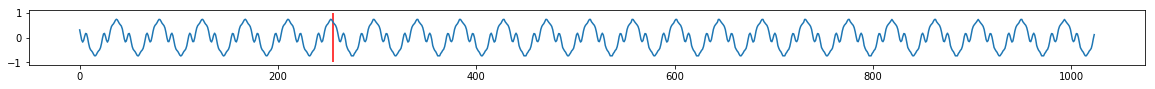

2019-01-22 13:33:04 Epoch [0/1], Step [3625/12187] Loss: 1.6765
2019-01-22 13:33:44 Epoch [0/1], Step [3650/12187] Loss: 1.6823
2019-01-22 13:34:24 Epoch [0/1], Step [3675/12187] Loss: 1.6666
2019-01-22 13:35:04 Epoch [0/1], Step [3700/12187] Loss: 1.7825
2019-01-22 13:35:44 Epoch [0/1], Step [3725/12187] Loss: 1.7953
2019-01-22 13:36:23 Epoch [0/1], Step [3750/12187] Loss: 1.7143
2019-01-22 13:37:03 Epoch [0/1], Step [3775/12187] Loss: 1.6668
2019-01-22 13:37:43 Epoch [0/1], Step [3800/12187] Loss: 1.6831


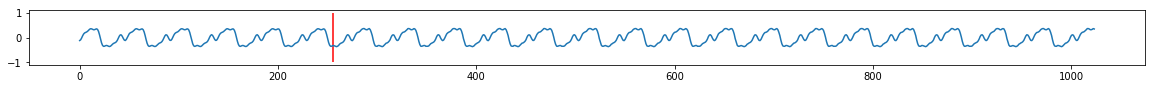

2019-01-22 13:38:26 Epoch [0/1], Step [3825/12187] Loss: 1.6523
2019-01-22 13:39:06 Epoch [0/1], Step [3850/12187] Loss: 1.6757
2019-01-22 13:39:46 Epoch [0/1], Step [3875/12187] Loss: 1.6816
2019-01-22 13:40:26 Epoch [0/1], Step [3900/12187] Loss: 1.6916
2019-01-22 13:41:06 Epoch [0/1], Step [3925/12187] Loss: 1.6656
2019-01-22 13:41:46 Epoch [0/1], Step [3950/12187] Loss: 1.6517
2019-01-22 13:42:26 Epoch [0/1], Step [3975/12187] Loss: 1.6865
2019-01-22 13:43:05 Epoch [0/1], Step [4000/12187] Loss: 1.7051


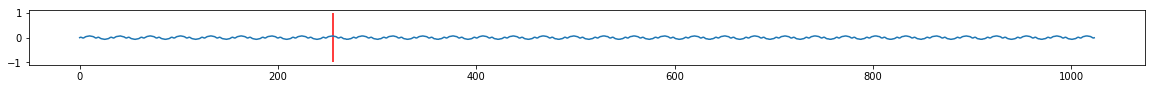

model 2019-01-22_11-51-12_model_epoch0_step4000.tar saved
2019-01-22 13:43:48 Epoch [0/1], Step [4025/12187] Loss: 1.6577
2019-01-22 13:44:29 Epoch [0/1], Step [4050/12187] Loss: 1.6635
2019-01-22 13:45:09 Epoch [0/1], Step [4075/12187] Loss: 1.6516
2019-01-22 13:45:49 Epoch [0/1], Step [4100/12187] Loss: 1.6882
2019-01-22 13:46:28 Epoch [0/1], Step [4125/12187] Loss: 1.6639
2019-01-22 13:47:08 Epoch [0/1], Step [4150/12187] Loss: 1.6222
2019-01-22 13:47:48 Epoch [0/1], Step [4175/12187] Loss: 1.6897
2019-01-22 13:48:28 Epoch [0/1], Step [4200/12187] Loss: 1.6649


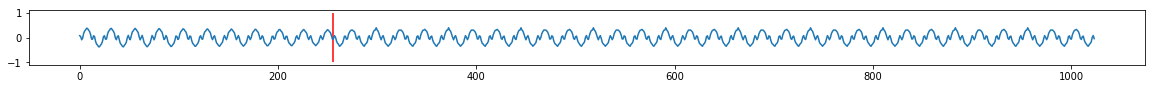

2019-01-22 13:49:11 Epoch [0/1], Step [4225/12187] Loss: 1.6096
2019-01-22 13:49:56 Epoch [0/1], Step [4250/12187] Loss: 1.7826
2019-01-22 13:50:41 Epoch [0/1], Step [4275/12187] Loss: 1.7005
2019-01-22 13:51:20 Epoch [0/1], Step [4300/12187] Loss: 1.6196
2019-01-22 13:52:00 Epoch [0/1], Step [4325/12187] Loss: 1.6139
2019-01-22 13:52:39 Epoch [0/1], Step [4350/12187] Loss: 1.6660
2019-01-22 13:53:19 Epoch [0/1], Step [4375/12187] Loss: 1.6797
2019-01-22 13:53:59 Epoch [0/1], Step [4400/12187] Loss: 1.6080


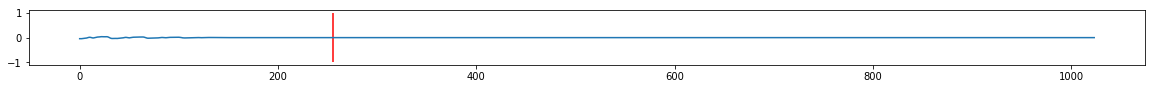

2019-01-22 13:54:44 Epoch [0/1], Step [4425/12187] Loss: 1.6177
2019-01-22 13:55:25 Epoch [0/1], Step [4450/12187] Loss: 1.6756
2019-01-22 13:56:06 Epoch [0/1], Step [4475/12187] Loss: 1.5991
2019-01-22 13:56:47 Epoch [0/1], Step [4500/12187] Loss: 1.6285
2019-01-22 13:57:27 Epoch [0/1], Step [4525/12187] Loss: 1.6326
2019-01-22 13:58:08 Epoch [0/1], Step [4550/12187] Loss: 1.5971
2019-01-22 13:58:49 Epoch [0/1], Step [4575/12187] Loss: 1.6386
2019-01-22 13:59:31 Epoch [0/1], Step [4600/12187] Loss: 1.6219


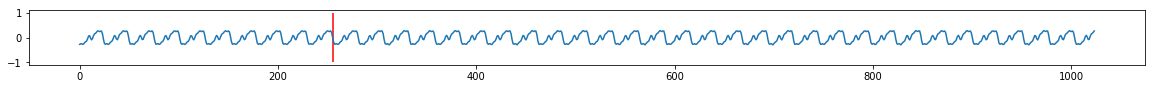

2019-01-22 14:00:15 Epoch [0/1], Step [4625/12187] Loss: 1.6089
2019-01-22 14:00:56 Epoch [0/1], Step [4650/12187] Loss: 1.6508
2019-01-22 14:01:37 Epoch [0/1], Step [4675/12187] Loss: 1.6736
2019-01-22 14:02:17 Epoch [0/1], Step [4700/12187] Loss: 1.6703
2019-01-22 14:02:58 Epoch [0/1], Step [4725/12187] Loss: 1.6140
2019-01-22 14:03:39 Epoch [0/1], Step [4750/12187] Loss: 1.5877
2019-01-22 14:04:20 Epoch [0/1], Step [4775/12187] Loss: 1.5961
2019-01-22 14:05:01 Epoch [0/1], Step [4800/12187] Loss: 1.5991


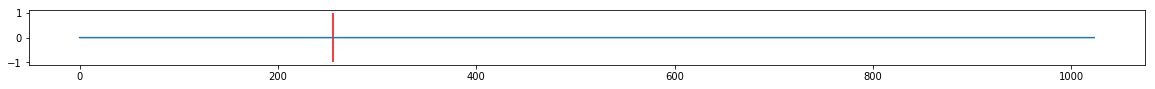

2019-01-22 14:05:44 Epoch [0/1], Step [4825/12187] Loss: 1.5898
2019-01-22 14:06:24 Epoch [0/1], Step [4850/12187] Loss: 1.6170
2019-01-22 14:07:04 Epoch [0/1], Step [4875/12187] Loss: 1.5941
2019-01-22 14:07:43 Epoch [0/1], Step [4900/12187] Loss: 1.6025
2019-01-22 14:08:26 Epoch [0/1], Step [4925/12187] Loss: 1.5991
2019-01-22 14:09:08 Epoch [0/1], Step [4950/12187] Loss: 1.6220
2019-01-22 14:09:50 Epoch [0/1], Step [4975/12187] Loss: 1.6078
2019-01-22 14:10:32 Epoch [0/1], Step [5000/12187] Loss: 1.5908


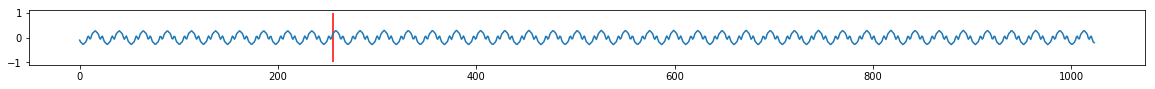

model 2019-01-22_11-51-12_model_epoch0_step5000.tar saved
2019-01-22 14:11:17 Epoch [0/1], Step [5025/12187] Loss: 1.6064
2019-01-22 14:11:58 Epoch [0/1], Step [5050/12187] Loss: 1.5793
2019-01-22 14:12:40 Epoch [0/1], Step [5075/12187] Loss: 1.5932
2019-01-22 14:13:21 Epoch [0/1], Step [5100/12187] Loss: 1.6152
2019-01-22 14:14:03 Epoch [0/1], Step [5125/12187] Loss: 1.5736
2019-01-22 14:14:44 Epoch [0/1], Step [5150/12187] Loss: 1.6483
2019-01-22 14:15:25 Epoch [0/1], Step [5175/12187] Loss: 1.5743
2019-01-22 14:16:07 Epoch [0/1], Step [5200/12187] Loss: 1.5625


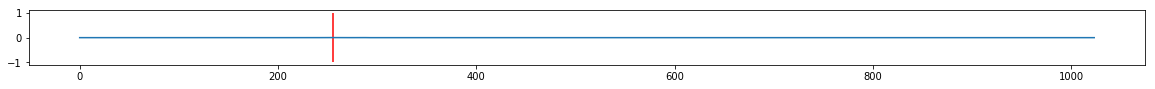

2019-01-22 14:16:52 Epoch [0/1], Step [5225/12187] Loss: 1.6011
2019-01-22 14:17:33 Epoch [0/1], Step [5250/12187] Loss: 1.5454
2019-01-22 14:18:15 Epoch [0/1], Step [5275/12187] Loss: 1.7601
2019-01-22 14:18:56 Epoch [0/1], Step [5300/12187] Loss: 1.6609
2019-01-22 14:19:38 Epoch [0/1], Step [5325/12187] Loss: 1.5968
2019-01-22 14:20:19 Epoch [0/1], Step [5350/12187] Loss: 1.5719
2019-01-22 14:21:01 Epoch [0/1], Step [5375/12187] Loss: 1.5507
2019-01-22 14:21:44 Epoch [0/1], Step [5400/12187] Loss: 1.5264


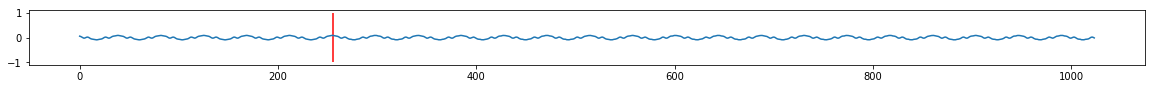

2019-01-22 14:22:32 Epoch [0/1], Step [5425/12187] Loss: 1.5778
2019-01-22 14:23:13 Epoch [0/1], Step [5450/12187] Loss: 1.5868
2019-01-22 14:23:54 Epoch [0/1], Step [5475/12187] Loss: 1.5531
2019-01-22 14:24:35 Epoch [0/1], Step [5500/12187] Loss: 1.5746
2019-01-22 14:25:18 Epoch [0/1], Step [5525/12187] Loss: 1.5720
2019-01-22 14:25:59 Epoch [0/1], Step [5550/12187] Loss: 1.5348
2019-01-22 14:26:40 Epoch [0/1], Step [5575/12187] Loss: 1.5711
2019-01-22 14:27:22 Epoch [0/1], Step [5600/12187] Loss: 1.5694


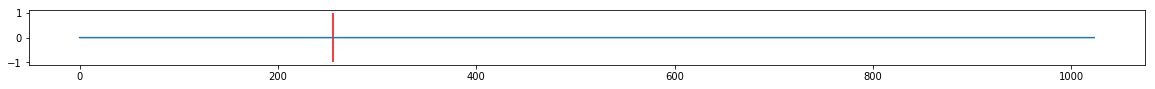

2019-01-22 14:28:07 Epoch [0/1], Step [5625/12187] Loss: 1.5596
2019-01-22 14:28:49 Epoch [0/1], Step [5650/12187] Loss: 1.5585
2019-01-22 14:29:30 Epoch [0/1], Step [5675/12187] Loss: 1.5542
2019-01-22 14:30:12 Epoch [0/1], Step [5700/12187] Loss: 1.5712
2019-01-22 14:30:54 Epoch [0/1], Step [5725/12187] Loss: 1.5520
2019-01-22 14:31:35 Epoch [0/1], Step [5750/12187] Loss: 1.5855
2019-01-22 14:32:17 Epoch [0/1], Step [5775/12187] Loss: 1.5812
2019-01-22 14:32:58 Epoch [0/1], Step [5800/12187] Loss: 1.5284


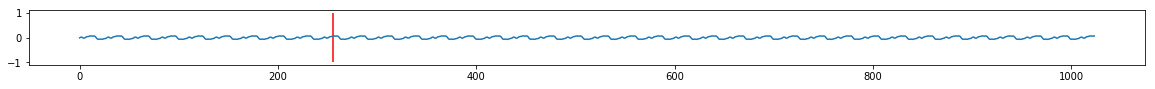

2019-01-22 14:33:43 Epoch [0/1], Step [5825/12187] Loss: 1.5301
2019-01-22 14:34:25 Epoch [0/1], Step [5850/12187] Loss: 1.5345
2019-01-22 14:35:06 Epoch [0/1], Step [5875/12187] Loss: 1.5387
2019-01-22 14:35:48 Epoch [0/1], Step [5900/12187] Loss: 1.5567
2019-01-22 14:36:29 Epoch [0/1], Step [5925/12187] Loss: 1.5321
2019-01-22 14:37:11 Epoch [0/1], Step [5950/12187] Loss: 1.5726
2019-01-22 14:37:52 Epoch [0/1], Step [5975/12187] Loss: 1.5355
2019-01-22 14:38:33 Epoch [0/1], Step [6000/12187] Loss: 1.4936


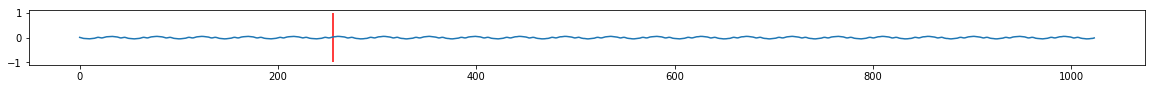

model 2019-01-22_11-51-12_model_epoch0_step6000.tar saved
2019-01-22 14:39:18 Epoch [0/1], Step [6025/12187] Loss: 1.5403
2019-01-22 14:40:00 Epoch [0/1], Step [6050/12187] Loss: 1.5312
2019-01-22 14:40:41 Epoch [0/1], Step [6075/12187] Loss: 1.5329
2019-01-22 14:41:23 Epoch [0/1], Step [6100/12187] Loss: 1.5259
2019-01-22 14:42:04 Epoch [0/1], Step [6125/12187] Loss: 1.5061
2019-01-22 14:42:45 Epoch [0/1], Step [6150/12187] Loss: 1.6434
2019-01-22 14:43:27 Epoch [0/1], Step [6175/12187] Loss: 1.6869
2019-01-22 14:44:08 Epoch [0/1], Step [6200/12187] Loss: 1.5676


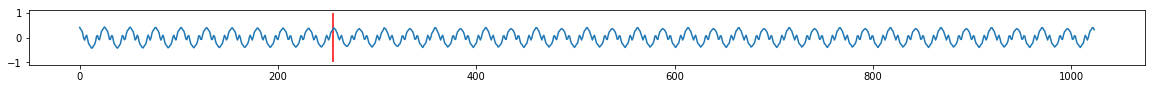

2019-01-22 14:44:54 Epoch [0/1], Step [6225/12187] Loss: 1.5131
2019-01-22 14:45:35 Epoch [0/1], Step [6250/12187] Loss: 1.5175
2019-01-22 14:46:17 Epoch [0/1], Step [6275/12187] Loss: 1.5171
2019-01-22 14:46:58 Epoch [0/1], Step [6300/12187] Loss: 1.5423
2019-01-22 14:47:40 Epoch [0/1], Step [6325/12187] Loss: 1.4823
2019-01-22 14:48:22 Epoch [0/1], Step [6350/12187] Loss: 1.5461
2019-01-22 14:49:04 Epoch [0/1], Step [6375/12187] Loss: 1.5134
2019-01-22 14:49:46 Epoch [0/1], Step [6400/12187] Loss: 1.5456


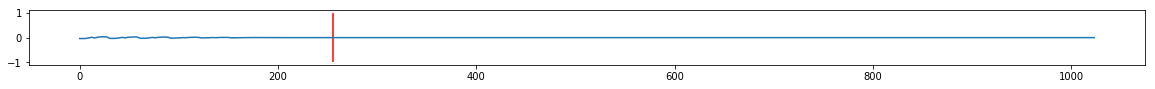

2019-01-22 14:50:30 Epoch [0/1], Step [6425/12187] Loss: 1.5035
2019-01-22 14:51:10 Epoch [0/1], Step [6450/12187] Loss: 1.5029
2019-01-22 14:51:50 Epoch [0/1], Step [6475/12187] Loss: 1.4790
2019-01-22 14:52:31 Epoch [0/1], Step [6500/12187] Loss: 1.5347
2019-01-22 14:53:11 Epoch [0/1], Step [6525/12187] Loss: 1.5396
2019-01-22 14:53:51 Epoch [0/1], Step [6550/12187] Loss: 1.5150
2019-01-22 14:54:31 Epoch [0/1], Step [6575/12187] Loss: 1.5191
2019-01-22 14:55:11 Epoch [0/1], Step [6600/12187] Loss: 1.6068


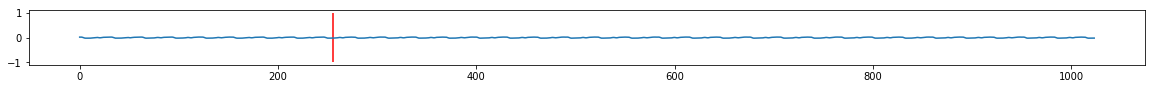

2019-01-22 14:55:54 Epoch [0/1], Step [6625/12187] Loss: 1.4961
2019-01-22 14:56:34 Epoch [0/1], Step [6650/12187] Loss: 1.4866
2019-01-22 14:57:14 Epoch [0/1], Step [6675/12187] Loss: 1.4978
2019-01-22 14:57:54 Epoch [0/1], Step [6700/12187] Loss: 1.7933
2019-01-22 14:58:35 Epoch [0/1], Step [6725/12187] Loss: 1.6747
2019-01-22 14:59:15 Epoch [0/1], Step [6750/12187] Loss: 1.5524
2019-01-22 14:59:55 Epoch [0/1], Step [6775/12187] Loss: 1.5344
2019-01-22 15:00:35 Epoch [0/1], Step [6800/12187] Loss: 1.5599


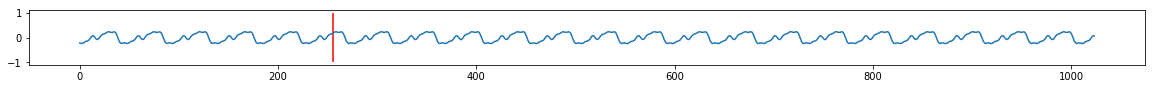

2019-01-22 15:01:19 Epoch [0/1], Step [6825/12187] Loss: 1.4841
2019-01-22 15:01:59 Epoch [0/1], Step [6850/12187] Loss: 1.4534
2019-01-22 15:02:39 Epoch [0/1], Step [6875/12187] Loss: 1.4867
2019-01-22 15:03:19 Epoch [0/1], Step [6900/12187] Loss: 1.4558
2019-01-22 15:03:59 Epoch [0/1], Step [6925/12187] Loss: 1.5200
2019-01-22 15:04:39 Epoch [0/1], Step [6950/12187] Loss: 1.4854
2019-01-22 15:05:19 Epoch [0/1], Step [6975/12187] Loss: 1.4768
2019-01-22 15:05:59 Epoch [0/1], Step [7000/12187] Loss: 1.4711


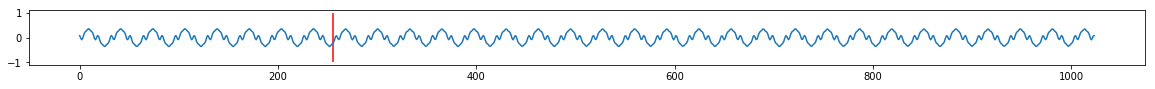

model 2019-01-22_11-51-12_model_epoch0_step7000.tar saved
2019-01-22 15:06:42 Epoch [0/1], Step [7025/12187] Loss: 1.4956
2019-01-22 15:07:22 Epoch [0/1], Step [7050/12187] Loss: 1.5248
2019-01-22 15:08:02 Epoch [0/1], Step [7075/12187] Loss: 1.4714
2019-01-22 15:08:42 Epoch [0/1], Step [7100/12187] Loss: 1.4953
2019-01-22 15:09:22 Epoch [0/1], Step [7125/12187] Loss: 1.5496
2019-01-22 15:10:02 Epoch [0/1], Step [7150/12187] Loss: 1.4602
2019-01-22 15:10:42 Epoch [0/1], Step [7175/12187] Loss: 1.4711
2019-01-22 15:11:22 Epoch [0/1], Step [7200/12187] Loss: 1.4524


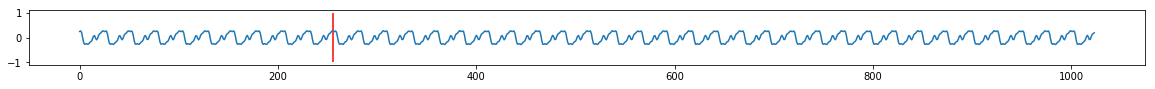

2019-01-22 15:12:05 Epoch [0/1], Step [7225/12187] Loss: 1.4820
2019-01-22 15:12:45 Epoch [0/1], Step [7250/12187] Loss: 1.4890
2019-01-22 15:13:25 Epoch [0/1], Step [7275/12187] Loss: 1.5194
2019-01-22 15:14:05 Epoch [0/1], Step [7300/12187] Loss: 1.5146
2019-01-22 15:14:45 Epoch [0/1], Step [7325/12187] Loss: 1.5146
2019-01-22 15:15:24 Epoch [0/1], Step [7350/12187] Loss: 1.4854
2019-01-22 15:16:04 Epoch [0/1], Step [7375/12187] Loss: 1.4592
2019-01-22 15:16:44 Epoch [0/1], Step [7400/12187] Loss: 1.4992


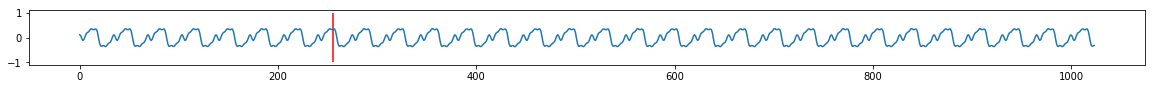

2019-01-22 15:17:27 Epoch [0/1], Step [7425/12187] Loss: 1.4936
2019-01-22 15:18:06 Epoch [0/1], Step [7450/12187] Loss: 1.5139
2019-01-22 15:18:46 Epoch [0/1], Step [7475/12187] Loss: 1.4853
2019-01-22 15:19:26 Epoch [0/1], Step [7500/12187] Loss: 1.5109
2019-01-22 15:20:06 Epoch [0/1], Step [7525/12187] Loss: 1.4811
2019-01-22 15:20:46 Epoch [0/1], Step [7550/12187] Loss: 1.5252
2019-01-22 15:21:26 Epoch [0/1], Step [7575/12187] Loss: 1.5399
2019-01-22 15:22:05 Epoch [0/1], Step [7600/12187] Loss: 1.4820


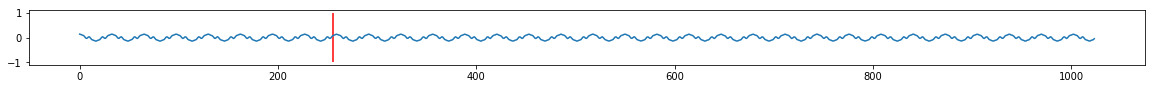

2019-01-22 15:22:49 Epoch [0/1], Step [7625/12187] Loss: 1.5240
2019-01-22 15:23:28 Epoch [0/1], Step [7650/12187] Loss: 1.4488
2019-01-22 15:24:08 Epoch [0/1], Step [7675/12187] Loss: 1.4495
2019-01-22 15:24:48 Epoch [0/1], Step [7700/12187] Loss: 1.4487
2019-01-22 15:25:27 Epoch [0/1], Step [7725/12187] Loss: 1.4512
2019-01-22 15:26:07 Epoch [0/1], Step [7750/12187] Loss: 1.4456
2019-01-22 15:26:47 Epoch [0/1], Step [7775/12187] Loss: 1.4692
2019-01-22 15:27:27 Epoch [0/1], Step [7800/12187] Loss: 1.4506


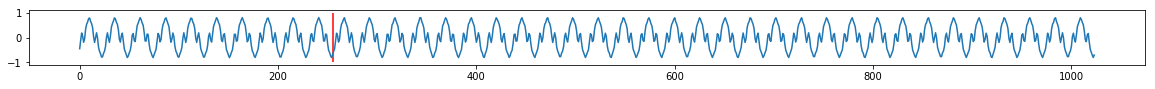

2019-01-22 15:28:11 Epoch [0/1], Step [7825/12187] Loss: 1.4626
2019-01-22 15:28:51 Epoch [0/1], Step [7850/12187] Loss: 1.5689
2019-01-22 15:29:31 Epoch [0/1], Step [7875/12187] Loss: 1.6337
2019-01-22 15:30:11 Epoch [0/1], Step [7900/12187] Loss: 1.4911
2019-01-22 15:30:50 Epoch [0/1], Step [7925/12187] Loss: 1.4347
2019-01-22 15:31:30 Epoch [0/1], Step [7950/12187] Loss: 1.4578
2019-01-22 15:32:10 Epoch [0/1], Step [7975/12187] Loss: 1.4456
2019-01-22 15:32:50 Epoch [0/1], Step [8000/12187] Loss: 1.4616


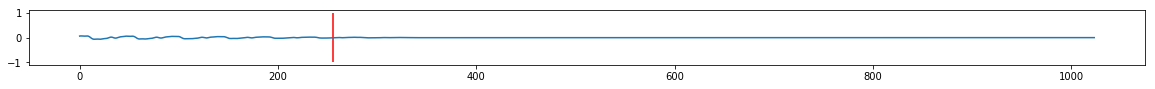

model 2019-01-22_11-51-12_model_epoch0_step8000.tar saved
2019-01-22 15:33:33 Epoch [0/1], Step [8025/12187] Loss: 1.4199
2019-01-22 15:34:13 Epoch [0/1], Step [8050/12187] Loss: 1.5033
2019-01-22 15:34:52 Epoch [0/1], Step [8075/12187] Loss: 1.4188
2019-01-22 15:35:32 Epoch [0/1], Step [8100/12187] Loss: 1.5262
2019-01-22 15:36:12 Epoch [0/1], Step [8125/12187] Loss: 1.4224
2019-01-22 15:36:51 Epoch [0/1], Step [8150/12187] Loss: 1.4779
2019-01-22 15:37:31 Epoch [0/1], Step [8175/12187] Loss: 1.4151
2019-01-22 15:38:11 Epoch [0/1], Step [8200/12187] Loss: 1.5105


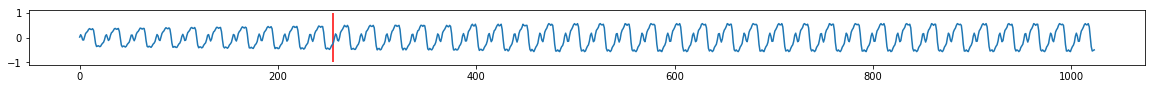

2019-01-22 15:38:54 Epoch [0/1], Step [8225/12187] Loss: 1.4227
2019-01-22 15:39:33 Epoch [0/1], Step [8250/12187] Loss: 1.4743
2019-01-22 15:40:13 Epoch [0/1], Step [8275/12187] Loss: 1.4728
2019-01-22 15:40:53 Epoch [0/1], Step [8300/12187] Loss: 1.4107
2019-01-22 15:41:32 Epoch [0/1], Step [8325/12187] Loss: 1.4579
2019-01-22 15:42:12 Epoch [0/1], Step [8350/12187] Loss: 1.4304
2019-01-22 15:42:52 Epoch [0/1], Step [8375/12187] Loss: 1.4449
2019-01-22 15:43:32 Epoch [0/1], Step [8400/12187] Loss: 1.4511


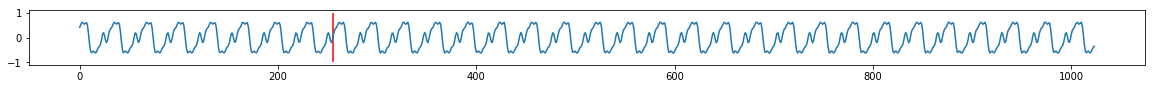

2019-01-22 15:44:20 Epoch [0/1], Step [8425/12187] Loss: 1.4451
2019-01-22 15:45:05 Epoch [0/1], Step [8450/12187] Loss: 1.4159
2019-01-22 15:45:47 Epoch [0/1], Step [8475/12187] Loss: 1.5002
2019-01-22 15:46:29 Epoch [0/1], Step [8500/12187] Loss: 1.4804
2019-01-22 15:47:12 Epoch [0/1], Step [8525/12187] Loss: 1.4557
2019-01-22 15:47:54 Epoch [0/1], Step [8550/12187] Loss: 1.4469
2019-01-22 15:48:35 Epoch [0/1], Step [8575/12187] Loss: 1.4403
2019-01-22 15:49:16 Epoch [0/1], Step [8600/12187] Loss: 1.4460


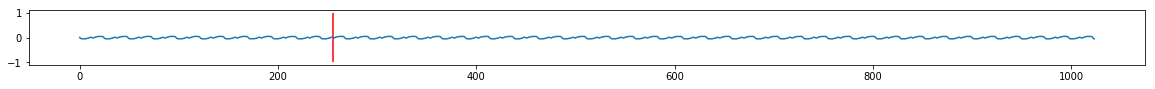

2019-01-22 15:50:02 Epoch [0/1], Step [8625/12187] Loss: 1.4646
2019-01-22 15:50:42 Epoch [0/1], Step [8650/12187] Loss: 1.4796
2019-01-22 15:51:24 Epoch [0/1], Step [8675/12187] Loss: 1.4613
2019-01-22 15:52:05 Epoch [0/1], Step [8700/12187] Loss: 1.4361
2019-01-22 15:52:45 Epoch [0/1], Step [8725/12187] Loss: 1.5092
2019-01-22 15:53:25 Epoch [0/1], Step [8750/12187] Loss: 1.3987
2019-01-22 15:54:05 Epoch [0/1], Step [8775/12187] Loss: 1.4357
2019-01-22 15:54:45 Epoch [0/1], Step [8800/12187] Loss: 1.4388


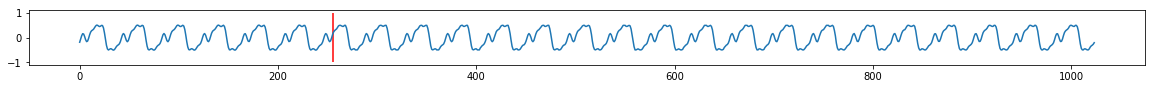

2019-01-22 15:55:29 Epoch [0/1], Step [8825/12187] Loss: 1.4989
2019-01-22 15:56:09 Epoch [0/1], Step [8850/12187] Loss: 1.4580
2019-01-22 15:56:49 Epoch [0/1], Step [8875/12187] Loss: 1.4571
2019-01-22 15:57:29 Epoch [0/1], Step [8900/12187] Loss: 1.4337
2019-01-22 15:58:10 Epoch [0/1], Step [8925/12187] Loss: 1.3922
2019-01-22 15:58:50 Epoch [0/1], Step [8950/12187] Loss: 1.4223
2019-01-22 15:59:30 Epoch [0/1], Step [8975/12187] Loss: 1.4487
2019-01-22 16:00:10 Epoch [0/1], Step [9000/12187] Loss: 1.4248


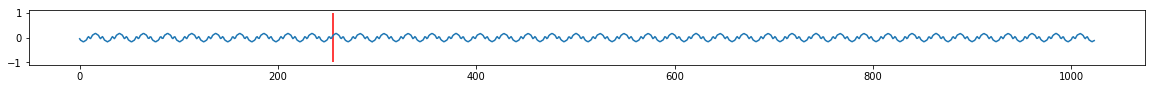

model 2019-01-22_11-51-12_model_epoch0_step9000.tar saved
2019-01-22 16:00:53 Epoch [0/1], Step [9025/12187] Loss: 1.4402
2019-01-22 16:01:33 Epoch [0/1], Step [9050/12187] Loss: 1.4353
2019-01-22 16:02:13 Epoch [0/1], Step [9075/12187] Loss: 1.4282
2019-01-22 16:02:53 Epoch [0/1], Step [9100/12187] Loss: 1.4502
2019-01-22 16:03:35 Epoch [0/1], Step [9125/12187] Loss: 1.4855
2019-01-22 16:04:18 Epoch [0/1], Step [9150/12187] Loss: 1.4377
2019-01-22 16:05:01 Epoch [0/1], Step [9175/12187] Loss: 1.3923
2019-01-22 16:05:45 Epoch [0/1], Step [9200/12187] Loss: 1.4431


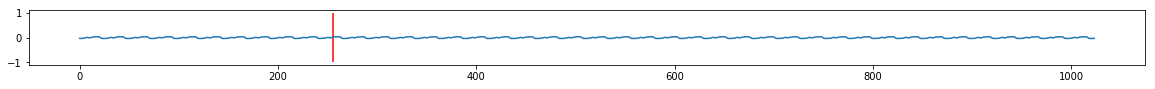

2019-01-22 16:06:33 Epoch [0/1], Step [9225/12187] Loss: 1.3962
2019-01-22 16:07:16 Epoch [0/1], Step [9250/12187] Loss: 1.4470
2019-01-22 16:07:58 Epoch [0/1], Step [9275/12187] Loss: 1.3813
2019-01-22 16:08:40 Epoch [0/1], Step [9300/12187] Loss: 1.4662
2019-01-22 16:09:23 Epoch [0/1], Step [9325/12187] Loss: 1.4426
2019-01-22 16:10:06 Epoch [0/1], Step [9350/12187] Loss: 1.4307
2019-01-22 16:10:49 Epoch [0/1], Step [9375/12187] Loss: 1.4069
2019-01-22 16:11:32 Epoch [0/1], Step [9400/12187] Loss: 1.4084


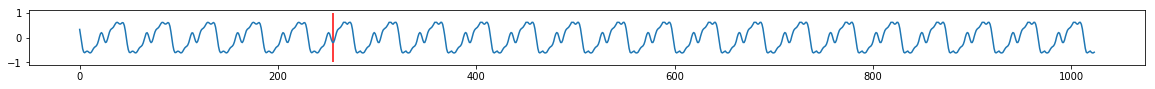

2019-01-22 16:12:19 Epoch [0/1], Step [9425/12187] Loss: 1.5083
2019-01-22 16:13:01 Epoch [0/1], Step [9450/12187] Loss: 1.4733
2019-01-22 16:13:43 Epoch [0/1], Step [9475/12187] Loss: 1.4722
2019-01-22 16:14:25 Epoch [0/1], Step [9500/12187] Loss: 1.4182
2019-01-22 16:15:08 Epoch [0/1], Step [9525/12187] Loss: 1.4234
2019-01-22 16:15:50 Epoch [0/1], Step [9550/12187] Loss: 1.3934
2019-01-22 16:16:32 Epoch [0/1], Step [9575/12187] Loss: 1.3999
2019-01-22 16:17:14 Epoch [0/1], Step [9600/12187] Loss: 1.4123


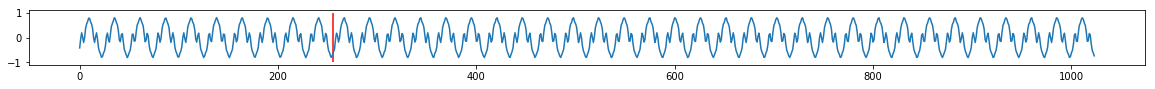

2019-01-22 16:18:03 Epoch [0/1], Step [9625/12187] Loss: 1.4009
2019-01-22 16:18:47 Epoch [0/1], Step [9650/12187] Loss: 1.4441
2019-01-22 16:19:30 Epoch [0/1], Step [9675/12187] Loss: 1.3922
2019-01-22 16:20:13 Epoch [0/1], Step [9700/12187] Loss: 1.4614
2019-01-22 16:20:56 Epoch [0/1], Step [9725/12187] Loss: 1.4200
2019-01-22 16:21:39 Epoch [0/1], Step [9750/12187] Loss: 1.4175
2019-01-22 16:22:22 Epoch [0/1], Step [9775/12187] Loss: 1.3720
2019-01-22 16:23:04 Epoch [0/1], Step [9800/12187] Loss: 1.3880


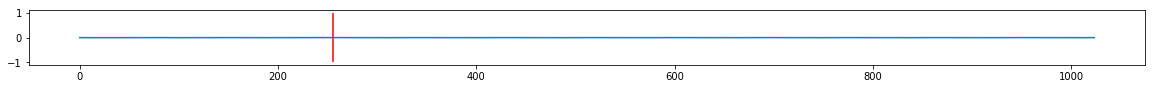

2019-01-22 16:23:49 Epoch [0/1], Step [9825/12187] Loss: 1.4051
2019-01-22 16:24:32 Epoch [0/1], Step [9850/12187] Loss: 1.3904
2019-01-22 16:25:14 Epoch [0/1], Step [9875/12187] Loss: 1.4239
2019-01-22 16:25:57 Epoch [0/1], Step [9900/12187] Loss: 1.3866
2019-01-22 16:26:40 Epoch [0/1], Step [9925/12187] Loss: 1.4124
2019-01-22 16:27:22 Epoch [0/1], Step [9950/12187] Loss: 1.3806
2019-01-22 16:28:06 Epoch [0/1], Step [9975/12187] Loss: 1.4277
2019-01-22 16:28:50 Epoch [0/1], Step [10000/12187] Loss: 1.4073


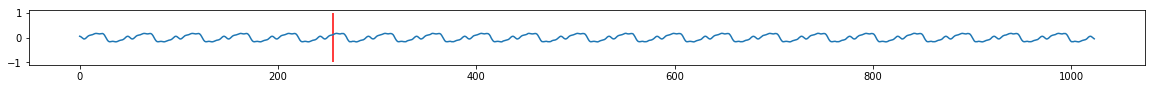

model 2019-01-22_11-51-12_model_epoch0_step10000.tar saved
model 2019-01-22_11-51-12_model_epoch0_step10001.tar saved
Training time taken: 4:37:43


In [11]:
# Train!
#*************************************
if not loadTrainingParams:
    start = '{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now())
print('{:%Y-%m-%d %H:%M:%S} Starting training at epoch{} step{}...'.format(datetime.now(),start_epoch,start_step))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(model,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel: #!NOTE the naming scheme for this saving part in still incorrect (for steps) 
    torch.save({#the checkpoint_dict here is slightly different from above since it can't access some local variables in training
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': list_of_losses,
                            'epoch': start_epoch+epoch,
                            'step': start_step,
                            'sample_rate': sr,
                            'start_time': start,
                            'datadir': datadir,
                            'paramdir': paramdir,
                            'savemodeldir': savemodeldir,
                            'seqLen': seqLen,
                            'stride': stride,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'lr': lr,
                            'log_interval': log_interval,
                            'max_steps': max_steps,
                            'teacher_forcing_ratio': teacher_forcing_ratio,                    
                            'prop': prop,
                            'output_size': output_size,
                            'hidden_size': hidden_size,
                            'n_layers': n_layers,
                            'noise': noise,
                            'lowNote': lowNote,
                            'hiNote': hiNote
                },                            
                    '{}/{}_{}_epoch{}_step{}.tar'.format(
                        savemodeldir,start,savename,start_epoch+epoch,start_step))
    print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step))
    
if savemodel_interval == num_epochs: #!NOTE the naming scheme for this saving part in still incorrect (for steps) 
    torch.save({#the checkpoint_dict here is slightly different from above since it can't access some local variables in training
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': list_of_losses,
                            'epoch': start_epoch+epoch,
                            'step': start_step,
                            'sample_rate': sr,
                            'start_time': start,
                            'datadir': datadir,
                            'paramdir': paramdir,
                            'savemodeldir': savemodeldir,
                            'seqLen': seqLen,
                            'stride': stride,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'lr': lr,
                            'log_interval': log_interval,
                            'max_steps': max_steps,
                            'teacher_forcing_ratio': teacher_forcing_ratio,                    
                            'prop': prop,
                            'output_size': output_size,
                            'hidden_size': hidden_size,
                            'n_layers': n_layers,
                            'noise': noise,
                            'lowNote': lowNote,
                            'hiNote': hiNote
                },                            
                    '{}/{}_{}_epoch{}_step{}.tar'.format(
                        savemodeldir,start,savename,start_epoch+epoch,start_step))
    print('model {}_{}_epoch{}_step{}.tar saved'.format(start,savename,start_epoch+epoch,start_step))

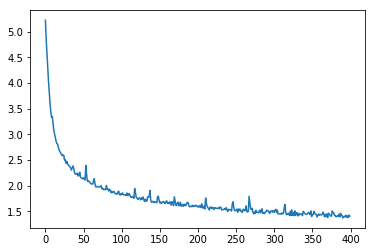

In [12]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)